In [21]:
##################################################################################################################################
#                                                                                                                                #
#                  A FRAMEWORK FOR EXPLAINABLE AI FOR SATELLITE NETWORKS ANOMALY DETECTION                                       #
#                                                                                                                                #
#                                                                                                                                #
#                                          *******   Beam Handover Anomalies   *******                                           #
#                                                                                                                                #
#                                                                                                                                #
#                                                    University of Hull                                                          #
#                                                MSc Artificial Intelligence                                                     #
#                                                                                                                                #
#                                                      Amadiz Sabino                                                             #
#                                                                                                                                #
##################################################################################################################################

# 1) ENV & DATA ACCESS
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Mount Google Drive
#   - Define DATA_DIR and artifact folder specific to this use case
#   - Quick sanity print of folder contents
# -------------------------------------------------------------------------------------------------
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses"
ART_DIR  = os.path.join(DATA_DIR, "artifacts_handover")
os.makedirs(ART_DIR, exist_ok=True)

!ls "$DATA_DIR"


Mounted at /content/drive
' 3_3_SES_Prototype_BeamHandover.ipynb'   artifacts_signal_loss
 3_3_SES_Prototype_SignalLoss.ipynb	  artifacts_sla
 3_3_SES_Prototype_SLA_Proxy.ipynb	  CIEL2_ManeuverEvents_R1.csv
 Archive				  ses_clean_10s.parquet
 artifacts_handover			  SESGroundData_Oct-Nov_AS1.xlsx


In [27]:
# 2) Import initial Librarires
# -------------------------------------------------------------------------------------------------
!pip -q install pandas numpy scikit-learn xgboost matplotlib

import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
import sys, numpy, pandas, sklearn, xgboost
print("Python", sys.version)
print("numpy", numpy.__version__)
print("pandas", pandas.__version__)
print("sklearn", sklearn.__version__)
print("xgboost", xgboost.__version__)

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
numpy 2.0.2
pandas 2.2.2
sklearn 1.6.1
xgboost 3.1.1


In [28]:
# 3) LOAD SES DATA
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Load base file
#   - Ensure strictly increasing datetime index
# -------------------------------------------------------------------------------------------------
path = os.path.join(DATA_DIR, "SESGroundData_Oct-Nov_AS1.xlsx")
df = pd.read_excel(path, sheet_name=0)

# If first row looks like headers repeated:
if df.iloc[0].isna().sum() < 5:
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)

time_col = "_time" if "_time" in df.columns else "timestamp"
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.set_index(time_col).sort_index()
df = df[~df.index.duplicated(keep="last")]

print("Time span:", df.index.min(), "→", df.index.max(), "| rows:", len(df))
df.head(3)


Time span: 2021-10-18 07:25:10+00:00 → 2021-11-30 23:59:50+00:00 | rows: 377489


,ANT_1_ACU,ANT_2_ACU,ANT_3_ACU,ANT_4_ACU,MODEM__10_IN,MODEM__10_OUT,MODEM__11_IN,MODEM__11_OUT,MODEM__14_IN,MODEM__14_OUT,...,MODEM__3_OUT,MODEM__4_IN,MODEM__4_OUT,MODEM__5_IN,MODEM__5_OUT,MODEM__8_IN,MODEM__8_OUT,MODEM__9_IN,MODEM__9_OUT,Spacecraft
_time,,,,,,,,,,,,,,,,,,,,,
2021-10-18 07:25:10+00:00,NaN,NaN,NaN,NaN,9.725,13.025,11.9000,12.1667,11.1000,18.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-18 07:25:20+00:00,NaN,NaN,NaN,NaN,10.650,12.975,11.7500,12.1000,11.1500,18.225,...,NaN,15.100,NaN,19.0333,20.0000,14.200,19.4,11.0333,14.4000,M010
2021-10-18 07:25:30+00:00,NaN,22.1649,NaN,NaN,9.900,12.800,11.8333,12.1000,11.0667,18.250,...,NaN,15.275,20.6,19.0000,20.1333,14.175,19.3,10.9750,14.3333,M010


In [29]:
# 4) DATA PREP (CLEAN -> RESAMPLE -> CLIP -> CONTEXT)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Numeric coercion
#   - Drop near-constant and super-sparse columns
#   - Resample to 10s cadence + short ffill
#   - Clipping of tails to de-glitch
#   - Maneuver mask integration (optional)
# -------------------------------------------------------------------------------------------------
num_df = df.copy()
for c in num_df.columns:
    if num_df[c].dtype == "object":
        num_df[c] = pd.to_numeric(num_df[c], errors="coerce")

def is_near_constant(s, tol=1e-9):
    s = s.dropna()
    return (s.max() - s.min()) <= tol

near_const = [c for c in num_df.columns if pd.api.types.is_numeric_dtype(num_df[c]) and is_near_constant(num_df[c])]
num_df = num_df.drop(columns=near_const)

# Drop sparse (>30% missing)
missing_pct = num_df.isna().mean()
sparse_cols = missing_pct[missing_pct > 0.30].index.tolist()
num_df = num_df.drop(columns=sparse_cols)

# Resample 10s, ffill ≤20s
res = num_df.resample("10s").last().ffill(limit=2)

# Clip to [0.5%, 99.5%] per column
q_low, q_high = res.quantile(0.005), res.quantile(0.995)
res = res.clip(lower=q_low, upper=q_high, axis=1)

# Optional maneuver mask
man_path = os.path.join(DATA_DIR, "CIEL2_ManeuverEvents_R1.csv")
maneuver_mask = pd.Series(False, index=res.index)
if os.path.exists(man_path):
    man = pd.read_csv(man_path, header=None, names=["StartTime","EndTime","EventType"])
    tz = res.index.tz
    man["StartTime"] = pd.to_datetime(man["StartTime"], errors="coerce")
    man["EndTime"]   = pd.to_datetime(man["EndTime"], errors="coerce")
    if tz is not None:
        man["StartTime"] = man["StartTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")
        man["EndTime"]   = man["EndTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")
    idx = res.index
    for s, e in zip(man["StartTime"], man["EndTime"]):
        if pd.isna(s) or pd.isna(e):
            continue
        s_clip, e_clip = max(s, idx[0]), min(e, idx[-1])
        if s_clip <= e_clip:
            maneuver_mask.loc[s_clip:e_clip] = True
    pad = pd.Timedelta(minutes=2)
    steps = int(pad.total_seconds()/10)
    padded = maneuver_mask.copy()
    padded |= maneuver_mask.shift(+steps, fill_value=False)
    padded |= maneuver_mask.shift(-steps, fill_value=False)
    maneuver_mask = maneuver_mask | padded
else:
    print("WARNING: Maneuver file not found:", man_path)

res = res.assign(in_maneuver = maneuver_mask.astype(int))
print("Resampled shape:", res.shape, "| maneuver fraction:", maneuver_mask.mean().round(3))


Resampled shape: (377489, 29) | maneuver fraction: 0.0


In [30]:
# 5) KPI DISCOVERY (Throughput proxy) + BEAM-STATE FEATURES
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Building a THROUGHPUT proxy from MODEM *_OUT (sum or robust mean).
#   - Building a "beam-state vector" from available MODEM channels (mostly *_OUT).
#   - These vectors will be clustered to infer beam IDs (states).
# -------------------------------------------------------------------------------------------------
import re

all_cols = list(res.columns)
num_cols = [c for c in all_cols if pd.api.types.is_numeric_dtype(res[c])]

# Throughput proxy
out_cols = [c for c in num_cols if re.search(r'_out$', c, flags=re.IGNORECASE)]
if len(out_cols) == 0:
    modem_cols = [c for c in num_cols if str(c).startswith("MODEM__")]
    out_cols = modem_cols

if len(out_cols) == 0:
    raise ValueError("No usable MODEM columns found to build throughput and beam vectors.")

thr_proxy = res[out_cols].clip(lower=0).sum(axis=1)
thr_name = "__THROUGHPUT_PROXY_Mbps"
res[thr_name] = thr_proxy

# Beam-state vector = normalized modem OUT vector (to emphasize pattern, not magnitude)
# Avoid division by zero:
vec = res[out_cols].fillna(0).clip(lower=0)
row_sum = vec.sum(axis=1).replace(0, np.nan)
beam_vec = (vec.T / row_sum).T.fillna(0)

print(f"Throughput proxy column: {thr_name} | beam vector dim={beam_vec.shape[1]}")
beam_vec.head(3)


Throughput proxy column: __THROUGHPUT_PROXY_Mbps | beam vector dim=14


,MODEM__11_OUT,MODEM__14_OUT,MODEM__16_OUT,MODEM__23_OUT,MODEM__24_OUT,MODEM__25_OUT,MODEM__26_OUT,MODEM__27_OUT,MODEM__28_OUT,MODEM__32_OUT,MODEM__4_OUT,MODEM__5_OUT,MODEM__8_OUT,MODEM__9_OUT
_time,,,,,,,,,,,,,,
2021-10-18 07:25:10+00:00,0.095065,0.142401,0.105743,0.069931,0.117203,0.120133,0.147154,0.109910,0.092460,0.000000,0.000000,0.000000,0.000000,0.000000
2021-10-18 07:25:20+00:00,0.066707,0.100473,0.074976,0.049341,0.082418,0.083429,0.103827,0.077181,0.065053,0.000000,0.000000,0.110259,0.106951,0.079386
2021-10-18 07:25:30+00:00,0.055718,0.084037,0.063085,0.039831,0.069071,0.069762,0.086723,0.064313,0.053876,0.071144,0.094858,0.092709,0.088872,0.066001


[Step6] beam_vec shape: (377489, 14)  range: 2021-10-18 07:25:10+00:00 → 2021-11-30 23:59:50+00:00
[Step6] TRAIN rows: 226493 | ALL rows: 377489
[Step6] PCA dims: 6 | variance explained: 0.659
[Step6] K=2: silhouette@20000=0.350
[Step6] K=3: silhouette@20000=0.190
[Step6] K=4: silhouette@20000=0.212
[Step6] K=5: silhouette@20000=0.231
[Step6] K=6: silhouette@20000=0.241
[Step6] Chosen K=2 (silhouette=0.350)
[Step6] Unique beams: 2 | switches: 5271 | first 5 states: [0, 0, 0, 0, 0]
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/artifacts_beam/beam_scaler.joblib
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/artifacts_beam/beam_pca.joblib
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/artifacts_beam/beam_kmeans.joblib
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/artifacts_beam/beam_id_series.csv
Saved: /content/drive/MyDrive/Colab_N

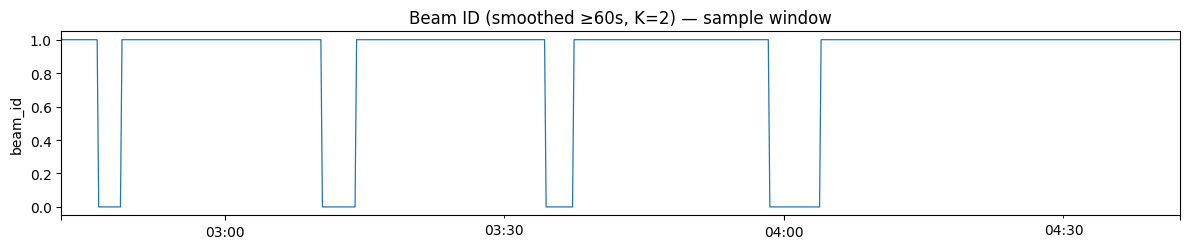

In [31]:
# 6) BEAM-ID INFERENCE (PCA + MiniBatchKMeans) WITH FAST K SELECTION
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Building a compact beam-state representation from modem vectors (beam_vec)
#   - Avoiding leakage: fit scaler + PCA on TRAIN only
#   - Choosing K via silhouette on a ~20k TRAIN subsample
#   - Fitting MiniBatchKMeans on full TRAIN; predict beam_id for ALL rows
#   - Smoothing short flickers (≥60s) to get stable beam_id
#   - Persist artifacts (scaler, pca, kmeans, beam_id, Z_* and K choice)
# Inputs expected:
#   - beam_vec : DataFrame (index=time)
#   - ART_DIR  : base folder
#   - If split1/split2 are not defined yet, we create provisional 60/20/20 splits by index
# -------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import joblib

# ---- Guards & provisional splits ----
assert 'beam_vec' in globals() and isinstance(beam_vec, pd.DataFrame), "beam_vec DataFrame missing."

# Create provisional time-ordered 60/20/20 splits if not provided yet
if 'split1' not in globals() or 'split2' not in globals():
    n_idx = len(beam_vec)
    split1 = int(n_idx * 0.60)  # TRAIN end
    split2 = int(n_idx * 0.80)  # VAL end / TEST start
    print(f"[Step6] Provisional splits created → split1={split1}, split2={split2} (60/20/20 by index)")

idx = beam_vec.index
n, d = beam_vec.shape
print(f"[Step6] beam_vec shape: {beam_vec.shape}  range: {idx.min()} → {idx.max()}")

# Artifacts folder
BASE_DIR = ART_DIR if 'ART_DIR' in globals() else "."
OUT = os.path.join(BASE_DIR, "artifacts_beam")
os.makedirs(OUT, exist_ok=True)

# ---- Train/All matrices (float32 for speed) ----
X_all = beam_vec.copy()

# ensure numeric
for c in X_all.columns:
    if X_all[c].dtype == 'object':
        X_all[c] = pd.to_numeric(X_all[c], errors='coerce')

# forward/backward fill (replaces deprecated fillna(method=...))
X_all = X_all.ffill().bfill().astype(np.float32)

# partition by index position (time-ordered)
X_train = X_all.iloc[:split1].copy()
print(f"[Step6] TRAIN rows: {len(X_train)} | ALL rows: {len(X_all)}")

# ---- Scale (TRAIN-only fit) ----
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_s = scaler.fit_transform(X_train.values)      # fit on TRAIN
X_all_s   = scaler.transform(X_all.values)            # transform ALL

# ---- PCA (TRAIN-only fit) ----
pca_k = min(6, X_all_s.shape[1])   # small, robust latent space
pca = PCA(n_components=pca_k, svd_solver='auto', random_state=42)
Z_train = pca.fit_transform(X_train_s).astype(np.float32)
Z_all   = pca.transform(X_all_s).astype(np.float32)

expl = float(pca.explained_variance_ratio_.sum())
print(f"[Step6] PCA dims: {pca_k} | variance explained: {expl:.3f}")

# ---- K selection: silhouette on TRAIN subsample ----
if len(Z_train) < 10:
    raise RuntimeError("[Step6] Not enough TRAIN rows for clustering. Check earlier steps.")

SAMPLE_N = min(20000, len(Z_train))
rng = np.random.RandomState(42)
perm = rng.choice(len(Z_train), SAMPLE_N, replace=False)
Z_sub = Z_train[perm]

best = {"k": None, "score": -1.0, "model": None}
for k in range(2, 7):  # try K = 2..6
    try:
        km = MiniBatchKMeans(
            n_clusters=k, batch_size=2048, n_init=5,
            max_iter=200, random_state=42, verbose=0
        )
        km.fit(Z_train)                       # fit on full TRAIN
        labs_sub = km.predict(Z_sub)
        sc = float(silhouette_score(Z_sub, labs_sub, metric="euclidean"))
        print(f"[Step6] K={k}: silhouette@{SAMPLE_N}={sc:.3f}")
        if sc > best["score"]:
            best = {"k": k, "score": sc, "model": km}
    except Exception as e:
        print(f"[Step6] K={k} silhouette failed: {e}")

# Fallback if nothing succeeded
if best["model"] is None:
    print("[Step6][WARN] Silhouette selection failed; falling back to K=2.")
    best["k"] = 2
    best["model"] = MiniBatchKMeans(
        n_clusters=2, batch_size=2048, n_init=5,
        max_iter=200, random_state=42, verbose=0
    ).fit(Z_train)
    best["score"] = -1.0

kmeans = best["model"]
print(f"[Step6] Chosen K={best['k']} (silhouette={best['score']:.3f})")

# ---- Predict clusters for all timestamps ----
beam_id_raw = kmeans.predict(Z_all)
beam_id_raw = pd.Series(beam_id_raw, index=idx, name="beam_id_raw")

# ---- Smooth flickers: collapse runs shorter than 60s to previous state ----
CADENCE_S = 10
min_len_steps = max(1, int(60 / CADENCE_S))  # 60s at 10s cadence = 6 steps

def smooth_states(s: pd.Series, min_len_steps: int = 6) -> pd.Series:
    x = s.values.copy()
    start = 0
    for i in range(1, len(x) + 1):
        if i == len(x) or x[i] != x[start]:
            run_len = i - start
            if run_len < min_len_steps and start > 0:
                x[start:i] = x[start - 1]
            start = i
    return pd.Series(x, index=s.index, name="beam_id")

beam_id = smooth_states(beam_id_raw, min_len_steps=min_len_steps)

# ---- Quick telemetry ----
n_switches = int((beam_id.shift(1) != beam_id).fillna(False).sum())
print(f"[Step6] Unique beams: {beam_id.nunique()} | switches: {n_switches} "
      f"| first 5 states: {beam_id.head().tolist()}")

# ---- Persist artifacts ----
joblib.dump(scaler, os.path.join(OUT, "beam_scaler.joblib"))
joblib.dump(pca,    os.path.join(OUT, "beam_pca.joblib"))
joblib.dump(kmeans, os.path.join(OUT, "beam_kmeans.joblib"))
beam_id.to_csv(os.path.join(OUT, "beam_id_series.csv"))
np.save(os.path.join(OUT, "Z_train.npy"), Z_train)
np.save(os.path.join(OUT, "Z_all.npy"),   Z_all)
with open(os.path.join(OUT, "k_choice.txt"), "w") as f:
    f.write(f"K={best['k']}, silhouette@{SAMPLE_N}={best['score']:.4f}\n")

print("Saved:", os.path.join(OUT, "beam_scaler.joblib"))
print("Saved:", os.path.join(OUT, "beam_pca.joblib"))
print("Saved:", os.path.join(OUT, "beam_kmeans.joblib"))
print("Saved:", os.path.join(OUT, "beam_id_series.csv"))

# ---- (Optional) small diagnostic plot over a ~2h window (centered) ----

mid = len(idx) // 2
half = 720 // 2
start = max(0, mid - half)
end = min(len(idx) - 1, mid + half)

try:
    #mid = len(idx) // 2
    #start = max(0, mid)
    #end = min(len(idx) - 1, mid + 720)  # ~2h at 10s cadence
    #--
    mid = len(idx) // 2
    half = 720 // 2
    start = max(0, mid - half)
    end = min(len(idx) - 1, mid + half)
    #--
    win = slice(idx[start], idx[end])
    fig, ax = plt.subplots(figsize=(12, 2.6))
    beam_id.loc[win].plot(ax=ax, lw=0.9)
    ax.set_title(f"Beam ID (smoothed ≥60s, K={best['k']}) — sample window")
    ax.set_ylabel("beam_id"); ax.set_xlabel("")
    plt.tight_layout()
    fig_path = os.path.join(OUT, "beam_id_sample.png")
    plt.savefig(fig_path, dpi=120)
    print("Saved:", fig_path)
except Exception as e:
    print("[Step6] Plot skipped:", e)

# Expose for downstream steps
BEAM_PCA_DIM = pca_k
BEAM_K       = best['k']


In [32]:
# 7) HANDOVER CANDIDATES + TRAINED THRESHOLDS + LABELS (DILATION PERSISTENCE)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Detect handovers from inferred beam_id (Step 6)
#   - Compute per-handover features:
#       * drop_pct  : pre→post throughput % drop
#       * since_prev: seconds since previous handover (ping-pong proxy)
#       * recovery_s: time until throughput returns within 90% of pre (capped)
#   - Learn anomaly thresholds from TRAIN only (robust percentiles with sensible fallbacks)
#   - Label anomalous handovers (instantaneous), then DILATE for PERSIST_S seconds
#   - Build early-warning labels by shifting forward (lead) in time
#   - Persist HOV table and learned thresholds
# -------------------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import json
import os

# ---- Guards & basics ----
assert 'res' in globals() and isinstance(res, pd.DataFrame), "Step 7 needs 'res' (Step 4 output)."
assert 'thr_name' in globals(), "Step 7 needs 'thr_name' (throughput proxy col)."
assert 'beam_id' in globals(), "Step 7 needs 'beam_id' (from Step 6)."
assert 'ART_DIR' in globals(), "Step 7 needs 'ART_DIR' to save artifacts."

CADENCE_S = 10  # we resampled to 10s in Step 4

# If Step 6 didn't export idx_train/idx_test, rebuild from split1/split2
if 'idx_train' not in globals() or 'idx_test' not in globals():
    assert 'split1' in globals() and 'split2' in globals(), "Need split1/split2 (from Step 6) to derive TRAIN/TEST windows."
    idx_all   = res.index
    idx_train = idx_all[:split1]
    idx_test  = idx_all[split2:]

# ---- Throughput series (light smoothing to reduce glitches) ----
thr = res[thr_name].copy()
thr = thr.rolling(3, min_periods=1).median()

# ---- Detect handover candidates (change in smoothed beam state from Step 6) ----
chg = (beam_id != beam_id.shift(1)).fillna(False).astype(int)
handover_ts = beam_id.index[chg.values == 1]

# ---- Helpers for per-handover features ----
def pre_post_means(ts, pre_s=120, post_s=180):
    """Mean throughput in pre/post windows around ts."""
    pre_n  = max(1, pre_s // CADENCE_S)
    post_n = max(1, post_s // CADENCE_S)
    loc = thr.index.get_indexer([ts])[0]
    pre  = thr.iloc[max(0, loc - pre_n):loc].mean()
    post = thr.iloc[loc:min(len(thr), loc + post_n)].mean()
    return pre, post

def recovery_time(ts, pre_value, tol=0.90, cap_s=1800):
    """Seconds until throughput >= tol * pre_value (capped)."""
    target = pre_value * tol
    loc = thr.index.get_indexer([ts])[0]
    for j in range(loc, min(len(thr), loc + cap_s // CADENCE_S)):
        if thr.iloc[j] >= target:
            return (thr.index[j] - ts).total_seconds()
    return float(cap_s)

def pct(s, p):
    s = pd.Series(s).dropna()
    return float(np.nanpercentile(s, p)) if len(s) else np.nan

# ---- Build per-handover feature table (HOV) ----
records = []
for t in handover_ts:
    pre, post = pre_post_means(t, pre_s=120, post_s=180)
    drop_pct = 0.0 if pre <= 0 else (pre - post) / pre
    records.append({"t": t, "pre": float(pre), "post": float(post), "drop_pct": float(drop_pct)})

HOV = pd.DataFrame.from_records(records).set_index("t").sort_index()
if not HOV.empty:
    # r2 proxy: seconds since previous handover
    HOV["since_prev_s"] = HOV.index.to_series().diff().dt.total_seconds().fillna(np.inf)
    # r3: recovery seconds back to 90% of pre (cap 30 min)
    HOV["recovery_s"] = [recovery_time(t, row["pre"], tol=0.90, cap_s=1800) for t, row in HOV.iterrows()]
else:
    HOV["since_prev_s"] = pd.Series(dtype=float)
    HOV["recovery_s"]   = pd.Series(dtype=float)

# ---- Learn anomaly thresholds from TRAIN only (robust & relaxed fallbacks) ----
HOV_train = HOV.loc[(HOV.index >= idx_train[0]) & (HOV.index <= idx_train[-1])]

# R1: post-handover drop threshold (use p90, but not below a minimum like 1%)
drop_thr = pct(HOV_train["drop_pct"], 90)
if np.isnan(drop_thr) or drop_thr < 0.01:
    drop_thr = 0.01  # 1% minimum sensitivity

# R2: ping-pong threshold (seconds). Use max(5 min, p40 of TRAIN spacing) to be more permissive.
ping_thr = max(300.0, pct(HOV_train["since_prev_s"], 40))
if np.isnan(ping_thr) or ping_thr < 300.0:
    ping_thr = 300.0

# R3: slow recovery threshold (seconds). Use p90 with a floor (≥45s) to catch long recoveries.
rec_thr = pct(HOV_train["recovery_s"], 90)
if np.isnan(rec_thr) or rec_thr < 45.0:
    rec_thr = 45.0

THR = {"drop_pct_thr": float(drop_thr), "pingpong_s": float(ping_thr), "recovery_s_thr": float(rec_thr)}
print("Learned (TRAIN) anomaly thresholds:", THR)

# ---- Apply rules to ALL handovers ----
#HOV["r1_drop"] = (HOV["drop_pct"] > THR["drop_pct_thr"]).astype(int)
#HOV["r2_ping"] = (HOV["since_prev_s"] < THR["pingpong_s"]).astype(int)
#HOV["r3_slow"] = (HOV["recovery_s"] > THR["recovery_s_thr"]).astype(int)
#HOV["anomalous"] = ((HOV["r1_drop"] | HOV["r2_ping"] | HOV["r3_slow"]) > 0).astype(int)

# Label anomalies for ALL handovers
HOV["r1_drop"] = (HOV["drop_pct"] > THR["drop_pct_thr"]).astype(int)

# HYBRID r2
window_s = min(float(THR["pingpong_s"]), 240.0)
mild_drop_thr = max(0.01, 0.25 * float(THR["drop_pct_thr"]))
pp_quick   = (HOV["since_prev_s"] < window_s)
pp_quality = (HOV["drop_pct"] > mild_drop_thr)
HOV["r2_ping"] = (pp_quick & pp_quality).astype(int)

HOV["r3_slow"]   = (HOV["recovery_s"] > THR["recovery_s_thr"]).astype(int)
HOV["anomalous"] = ((HOV["r1_drop"] | HOV["r2_ping"] | HOV["r3_slow"]) > 0).astype(int)


# Optional diagnostics: rule hit counts
if not HOV.empty:
    print("[Rule hits across ALL handovers] r1/r2/r3:", {
        "r1": int(HOV["r1_drop"].sum()),
        "r2": int(HOV["r2_ping"].sum()),
        "r3": int(HOV["r3_slow"].sum()),
        "any": int(HOV["anomalous"].sum())
    })

# ---- Label construction (dilation persistence) ----
# Starting with sparse 1's at anomalous handover instants
y_sparse = pd.Series(0, index=res.index, name="handover_anom_now")
if not HOV.empty:
    anom_ts = HOV.index[HOV["anomalous"] == 1]
    y_sparse.loc[anom_ts] = 1
y_sparse = y_sparse.astype(int)

# DILATE forward for PERSIST_S seconds so single-tick events become short windows (no "run==persist_steps" wipeout)
PERSIST_S = 30  # keep modest to avoid over-widening
persist_steps = max(1, int(PERSIST_S // CADENCE_S))

if y_sparse.sum() > 0 and persist_steps > 1:
    arr = y_sparse.values.copy()
    n = len(arr)
    ones_idx = np.flatnonzero(arr == 1)
    for i in ones_idx:
        j = min(n, i + persist_steps)   # paint [i, j) as 1
        arr[i:j] = 1
    y_now = pd.Series(arr, index=y_sparse.index, name="handover_anom_now").astype(int)
else:
    y_now = y_sparse.copy()

# Early warning target: shift forward by EARLY_WARNING_MIN minutes
EARLY_WARNING_MIN = 2
lead_steps = max(1, int((EARLY_WARNING_MIN * 60) // CADENCE_S))
y_lead = y_now.shift(-lead_steps).fillna(0).astype(int)

# ---- Telemetry ----
total_handovers   = int((beam_id != beam_id.shift(1)).fillna(False).sum())
total_anom_events = int(HOV["anomalous"].sum()) if not HOV.empty else 0
print(f"Label prevalence (now/lead): {y_now.mean():.4f} {y_lead.mean():.4f}")
print(f"[Labels] handovers={total_handovers} | anomalous={total_anom_events} "
      f"| after dilation sum(y_now)={int(y_now.sum())} lead sum(y_lead)={int(y_lead.sum())}")

# Daily counts for sanity (lead labels)
y_lead_daily = y_lead.groupby(pd.Grouper(freq="1D")).sum().rename("y_lead")
print("[Labels] Positives per day (lead):")
print(y_lead_daily.loc[y_lead_daily.index.min():y_lead_daily.index.max()].fillna(0).astype(int).tail(14))

# ---- Persist artifacts ----
HOV_path = os.path.join(ART_DIR, "handover_table.csv")
THR_path = os.path.join(ART_DIR, "handover_thresholds.json")
HOV.to_csv(HOV_path)
with open(THR_path, "w") as f:
    json.dump(THR, f, indent=2)
print("Saved:", HOV_path)
print("Saved:", THR_path)



Learned (TRAIN) anomaly thresholds: {'drop_pct_thr': 0.041967432986525284, 'pingpong_s': 300.0, 'recovery_s_thr': 45.0}
[Rule hits across ALL handovers] r1/r2/r3: {'r1': 427, 'r2': 1043, 'r3': 4, 'any': 1214}
Label prevalence (now/lead): 0.0096 0.0096
[Labels] handovers=5271 | anomalous=1214 | after dilation sum(y_now)=3642 lead sum(y_lead)=3639
[Labels] Positives per day (lead):
_time
2021-11-17 00:00:00+00:00    86
2021-11-18 00:00:00+00:00    40
2021-11-19 00:00:00+00:00     0
2021-11-20 00:00:00+00:00     0
2021-11-21 00:00:00+00:00     9
2021-11-22 00:00:00+00:00    24
2021-11-23 00:00:00+00:00     6
2021-11-24 00:00:00+00:00     9
2021-11-25 00:00:00+00:00    27
2021-11-26 00:00:00+00:00    36
2021-11-27 00:00:00+00:00    27
2021-11-28 00:00:00+00:00    36
2021-11-29 00:00:00+00:00    42
2021-11-30 00:00:00+00:00    51
Freq: D, Name: y_lead, dtype: int64
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/handover_table.csv
Saved: /content/drive/

In [38]:
# 8) FEATURES (enhanced) + LABEL-AWARE SPLITS + SCALING
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Build stronger features for handover anomaly prediction
#   - Ensure TRAIN/VAL both have positives via label-aware split search
#   - Scale using TRAIN-only; expose standardized names for Step 9

from sklearn.preprocessing import RobustScaler
import numpy as np, pandas as pd, joblib, os

assert 'res' in globals() and isinstance(res, pd.DataFrame), "Step 4+ dataframe `res` missing."
assert 'thr_name' in globals(), "Throughput proxy name `thr_name` missing."
assert 'beam_id' in globals(), "`beam_id` (from Step 6) missing."
assert 'y_lead' in globals() or 'y_now' in globals(), "Labels from Step 7 missing."

CADENCE_S = 10
USE_LOOKAHEAD_FEATURES = True   # set False for production/strictly causal features

def make_features(df: pd.DataFrame, beam_id_series: pd.Series, thr_col: str,
                  use_lookahead: bool = True) -> pd.DataFrame:
    """Feature recipe for handover anomalies (timeline)."""
    X = pd.DataFrame(index=df.index)
    s = df[thr_col].astype(float)

    # --- Rolling stats (10s cadence: 3≈30s, 12≈2m)
    X["thr"]           = s
    X["thr_mean_30s"]  = s.rolling(3,  min_periods=1).mean()
    X["thr_std_30s"]   = s.rolling(3,  min_periods=1).std()
    X["thr_mean_2m"]   = s.rolling(12, min_periods=1).mean()
    X["thr_std_2m"]    = s.rolling(12, min_periods=1).std()
    X["thr_slope_50s"] = s.diff().rolling(5, min_periods=1).mean()

    # --- Beam dynamics
    bid = beam_id_series.reindex(X.index).ffill().bfill()
    X["beam_id"] = bid
    change = (bid != bid.shift(1)).astype(int)
    X["beam_change_1"] = change

    # Dwell (since last change)
    steps_since = []
    last = None
    for i, val in enumerate(bid):
        if i == 0:
            steps_since.append(0); last = val; continue
        if val != last:
            steps_since.append(0); last = val
        else:
            steps_since.append(steps_since[-1] + 1)
    X["beam_steps_since_change"] = steps_since

    # Recent change rate
    X["chg_5m"]  = change.rolling(30,  min_periods=1).sum()
    X["chg_10m"] = change.rolling(60,  min_periods=1).sum()

    # --- Pre/Post deltas (research-time; for production set use_lookahead=False)
    X["thr_pre_2m"] = s.rolling(12, min_periods=1).mean()
    if use_lookahead:
        X["thr_post_2m"] = s.shift(-12).rolling(12, min_periods=1).mean()
        X["thr_delta"]   = X["thr_post_2m"] - X["thr_pre_2m"]
        X["thr_drop_pct"]= (X["thr_pre_2m"] - X["thr_post_2m"]) / X["thr_pre_2m"].replace(0, np.nan)
    else:
        # causal placeholder (EMA as proxy)
        X["thr_post_2m"] = X["thr_mean_2m"]
        X["thr_delta"]   = X["thr_mean_2m"] - X["thr_pre_2m"]
        X["thr_drop_pct"]= (X["thr_pre_2m"] - X["thr_mean_2m"]) / X["thr_pre_2m"].replace(0, np.nan)

    # Optional context
    if "in_maneuver" in df.columns:
        X["in_maneuver"] = df["in_maneuver"].astype(int)

    # Clean up
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X

# ---- Build features
X = make_features(res, beam_id, thr_name, use_lookahead=USE_LOOKAHEAD_FEATURES)

# ---- Align labels
y_all = (y_lead if 'y_lead' in globals() else y_now).reindex(X.index).fillna(0).astype(int)

# ---- Label-aware split search (ensure TRAIN & VAL have positives)
def find_splits(y, min_pos_train=3, min_pos_val=3,
                test_fracs=(0.20, 0.18, 0.15, 0.12, 0.10),
                train_fracs=(0.60, 0.55, 0.50, 0.45),
                val_fracs=(0.20, 0.25, 0.30)):
    n = len(y)
    def count_pos(s1, s2):
        return int(y.iloc[:s1].sum()), int(y.iloc[s1:s2].sum()), int(y.iloc[s2:].sum())

    best = None
    # Try classic 60/20/20 style first
    for tf in test_fracs:
        s2 = int(n * (1 - tf))
        for trf in train_fracs:
            s1 = int(n * trf)
            if s1 >= s2 or s1 < int(n * 0.30):  # guard
                continue
            tr, va, te = count_pos(s1, s2)
            if tr >= min_pos_train and va >= min_pos_val:
                best = (s1, s2, tr, va, te); break
        if best: break

    # If not found, fix TEST and vary VAL ahead of TEST
    if best is None:
        for tf in test_fracs:
            s2 = int(n * (1 - tf))
            for vaf in val_fracs:
                s1 = int(s2 - n * vaf)
                if s1 <= 0 or s1 >= s2:
                    continue
                tr, va, te = count_pos(s1, s2)
                if tr >= min_pos_train and va >= min_pos_val:
                    best = (s1, s2, tr, va, te); break
            if best: break
    return best

res_split = find_splits(y_all, min_pos_train=3, min_pos_val=3)
if res_split is None:
    raise ValueError(
        "[Step8] Could not find label-aware splits with positives in TRAIN and VAL. "
        "Relax label creation (lower PERSIST_S / thresholds) or shrink TEST slightly."
    )

split1, split2, tr_pos, va_pos, te_pos = res_split
n_total = len(X)
print(f"[Step8] n={n_total} | split1={split1} (TRAIN end), split2={split2} (VAL end / TEST start)")
print(f"[Step8] Positives -> TRAIN={tr_pos} | VAL={va_pos} | TEST={te_pos}")

# ---- Build splits (time-ordered)
X_train, y_train = X.iloc[:split1], y_all.iloc[:split1]
X_val,   y_val   = X.iloc[split1:split2], y_all.iloc[split1:split2]
X_test,  y_test  = X.iloc[split2:],       y_all.iloc[split2:]

print(f"[Step8] Shapes -> TRAIN={X_train.shape}, VAL={X_val.shape}, TEST={X_test.shape}")
print(f"[Step8] Label means (pos rate) -> TRAIN={y_train.mean():.4f} | VAL={y_val.mean():.4f} | TEST={y_test.mean():.4f}")

# ---- Scale (TRAIN only)
feat_scaler = RobustScaler()
#feat_scaler = RobustScaler()
#X_train_s = pd.DataFrame(feat_scaler.fit_transform(X_train), ...)
# …and persist feat_scaler instead of scaler

#scaler = RobustScaler()
X_train_s = pd.DataFrame(feat_scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_val_s   = pd.DataFrame(feat_scaler.transform(X_val),       index=X_val.index,   columns=X_val.columns)
X_test_s  = pd.DataFrame(feat_scaler.transform(X_test),      index=X_test.index,  columns=X_test.columns)

# ---- Expose standardized names for Step 9
X_train, X_val, X_test = X_train_s, X_val_s, X_test_s

# (Optional) persist scaler for reproducibility
try:
    base_dir = ART_DIR if 'ART_DIR' in globals() else "."
    os.makedirs(base_dir, exist_ok=True)
    scaler_path = os.path.join(base_dir, "scaler_step8.joblib")
    joblib.dump(scaler, scaler_path)
    print("Saved scaler:", scaler_path)
except Exception as e:
    print("Scaler save skipped:", e)


[Step8] n=377489 | split1=226493 (TRAIN end), split2=301991 (VAL end / TEST start)
[Step8] Positives -> TRAIN=2925 | VAL=462 | TEST=252
[Step8] Shapes -> TRAIN=(226493, 16), VAL=(75498, 16), TEST=(75498, 16)
[Step8] Label means (pos rate) -> TRAIN=0.0129 | VAL=0.0061 | TEST=0.0033
Saved scaler: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/scaler_step8.joblib


In [39]:
# 9) TRAIN MODEL (XGB, robust + early stopping via xgboost.train)
# -------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import average_precision_score, roc_auc_score

# --- Clean matrices (no NaN/Inf, float32)
def _clean(df):
    return df.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float32)

X_train = _clean(X_train)
X_val   = _clean(X_val)
X_test  = _clean(X_test)

y_train = y_train.astype(int)
y_val   = y_val.astype(int)
y_test  = y_test.astype(int)

print(f"[Step9] Shapes — TRAIN: {X_train.shape} (pos={int(y_train.sum())}), "
      f"VAL: {X_val.shape} (pos={int(y_val.sum())}), "
      f"TEST: {X_test.shape} (pos={int(y_test.sum())})")

# --- Imbalance setup
prev = float(y_train.mean())
base_score_safe    = float(np.clip(prev, 1e-6, 1 - 1e-6))
scale_pos_weight   = float((len(y_train) - y_train.sum()) / max(1, y_train.sum()))
print(f"[Step9] Imbalance setup -> prevalence={prev:.5f}, base_score={base_score_safe:.6f}, "
      f"scale_pos_weight={scale_pos_weight:.2f}")

# --- DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train.values)
dval   = xgb.DMatrix(X_val,   label=y_val.values)
dtest  = xgb.DMatrix(X_test)

# --- Params (binary logistic, PR-AUC early stop on VAL)
params = {
    "objective": "binary:logistic",
    "tree_method": "hist",
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "scale_pos_weight": scale_pos_weight,
    "base_score": base_score_safe,
    "eval_metric": "aucpr",
    "seed": 42,
}

# --- Train with early stopping
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,                 # upper cap; early stopping will prune
    evals=[(dtrain, "train"), (dval, "validation")],
    early_stopping_rounds=100,
    verbose_eval=False
)

best_iter = getattr(booster, "best_iteration", None)
if best_iter is not None:
    print(f"[Step9] Early stopping best_iteration: {best_iter}")

# --- Probabilities using best iteration
if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
    it_range = (0, booster.best_iteration + 1)
    proba_val  = booster.predict(dval,  iteration_range=it_range)
    proba_test = booster.predict(dtest, iteration_range=it_range)
else:
    proba_val  = booster.predict(dval)
    proba_test = booster.predict(dtest)

# --- Metrics
def _safe_metric(fn, y, p, name):
    try:
        v = fn(y, p)
        print(f"{name}: {v:.4f}")
        return float(v)
    except Exception as e:
        print(f"[Step9] {name} unavailable:", e)
        return float("nan")

ap_val = _safe_metric(average_precision_score, y_val,  proba_val,  "VAL — PR-AUC")
ap_te  = _safe_metric(average_precision_score, y_test, proba_test, "TEST — PR-AUC")
roc_te = _safe_metric(roc_auc_score,          y_test, proba_test, "TEST — ROC-AUC")

# Expose names used downstream
ap_va   = ap_val
clf     = booster            # keep a 'clf' handle; booster has .save_model(...)
test_index = X_test.index    # Step 11 expects test_index
print("[Step9] Done. Variables ready -> clf(booster), proba_val, proba_test, ap_val/ap_va, test_index")


[Step9] Shapes — TRAIN: (226493, 16) (pos=2925), VAL: (75498, 16) (pos=462), TEST: (75498, 16) (pos=252)
[Step9] Imbalance setup -> prevalence=0.01291, base_score=0.012914, scale_pos_weight=76.43
[Step9] Early stopping best_iteration: 226
VAL — PR-AUC: 0.1051
TEST — PR-AUC: 0.0222
TEST — ROC-AUC: 0.7065
[Step9] Done. Variables ready -> clf(booster), proba_val, proba_test, ap_val/ap_va, test_index


In [40]:
# Step 10
# Purpose: setting t with precision floor + alert budget guard ---
# t SELECTION — PRECISION-FIRST with ALERTS/DAY FALLBACK (Tiered)
# -------------------------------------------------------------------
from sklearn.metrics import precision_recall_curve
import numpy as np, pandas as pd

# ======== Main knobs (to be tweaked for adjustments) ========
# Precision-first policy
TARGET_PRECISION   = 0.85
RELAXED_PRECS      = [0.70, 0.60]   # try in order if 0.85 fails
MAX_POS_RATE_VAL   = 0.010          # ≤1.0% of VAL predicted positive
MIN_VAL_POS        = 10             # require ≥ this many VAL positives
FBETA               = 0.5           # precision-weighted tie-breaker

# Alerts/day fallback policy (on VAL)
TARGET_MIN_APD     = 3              # min alerts/day
TARGET_MAX_APD     = 15             # max alerts/day
PREC_FLOOR_FALLBK  = 0.60           # min precision when using alerts/day fallback
MAX_POS_PCT_FALLBK = 1.50           # ≤1.5% of VAL predicted positive

# Last resort
QUANT_FALLBACK_Q   = 0.995          # use VAL 99.5th percentile if all else fails















# -----======= Curves and common helpers ========
prec, rec, thr_raw = precision_recall_curve(y_val, proba_val)
# Align thresholds array length with prec/rec (append 1.0 as scikit does not include it)
tau_all = np.r_[thr_raw, 1.0]

df = pd.DataFrame({
    "tau": tau_all,
    "precision": prec,
    "recall": rec
}).sort_values("tau")

def _pos_counts(prob, taus):
    p = np.asarray(prob)
    return np.array([(p >= t).sum() for t in taus], dtype=int)

df["val_pos"]  = _pos_counts(proba_val,  df["tau"].values)
df["val_rate"] = df["val_pos"] / len(proba_val)
df["test_pos"] = _pos_counts(proba_test, df["tau"].values)

beta2 = FBETA**2
df["Fbeta"] = (1 + beta2) * (df["precision"] * df["recall"]) / np.clip(beta2 * df["precision"] + df["recall"], 1e-12, None)

print(f"[Step10] Validation Average Precision (AP): {average_precision_score(y_val, proba_val):.4f}")

# --- VAL duration in days (for alerts/day) ---
def _val_days():
    try:
        idx = X_val.index if "X_val" in globals() else y_val.index
        span = (idx[-1] - idx[0]).total_seconds()
        return max(span / 86400.0, 1e-6)
    except Exception:
        # fallback to 10s cadence assumption if index is not datetime-like
        return max(len(y_val) * 10.0 / 86400.0, 1e-6)

VAL_DAYS = _val_days()

def alerts_per_day_at_tau(tau):
    sig = (proba_val >= tau).astype(int)
    rises = np.diff(np.r_[0, sig, 0])
    events = (rises == 1).sum()
    return events / VAL_DAYS

def positives_pct_at_tau(tau):
    return 100.0 * (proba_val >= tau).mean()

# ======== Tier 1: Precision-first selection ========
def _pick_with_floor(floor):
    cand = df[
        (df["precision"] >= floor) &
        (df["val_rate"] <= MAX_POS_RATE_VAL) &
        (df["val_pos"]  >= MIN_VAL_POS)
    ]
    if len(cand):
        # Best Fbeta, then more conservative tau (higher)
        return cand.sort_values(["Fbeta", "tau"], ascending=[False, False]).iloc[0]
    return None

picked_by = None
row = _pick_with_floor(TARGET_PRECISION)
floor_used = TARGET_PRECISION if row is not None else None

if row is None:  # try relaxed floors
    for f in RELAXED_PRECS:
        r = _pick_with_floor(f)
        if r is not None:
            row = r
            floor_used = f
            break

if row is not None:
    thr_star = float(row["tau"])
    picked_by = "10 (precision-first)"
else:
    print("[Step10] No t satisfied precision-first constraints. Trying alerts/day fallback...")

# ======== Tier 2: Alerts/day fallback (only if Tier 1 failed) ========
if row is None:
    candidates = []
    for p, r, t in zip(df["precision"].values, df["recall"].values, df["tau"].values):
        apd = alerts_per_day_at_tau(t)
        pos_pct = positives_pct_at_tau(t)
        if (p >= PREC_FLOOR_FALLBK) and (TARGET_MIN_APD <= apd <= TARGET_MAX_APD) and (pos_pct <= MAX_POS_PCT_FALLBK):
            candidates.append((t, p, r, apd, pos_pct))

    if not candidates:
        # slightly looser final attempt within fallback tier
        for p, r, t in zip(df["precision"].values, df["recall"].values, df["tau"].values):
            apd = alerts_per_day_at_tau(t)
            pos_pct = positives_pct_at_tau(t)
            if (p >= 0.50) and (2 <= apd <= 20) and (pos_pct <= 2.0):
                candidates.append((t, p, r, apd, pos_pct))

    if candidates:
        def fbeta(p, r, b=FBETA):
            b2 = b*b
            return (1+b2)*p*r / (b2*p + r + 1e-9)
        best = max(candidates, key=lambda x: (fbeta(x[1], x[2], FBETA), x[1], x[2], -x[3]))
        thr_star = float(best[0])
        picked_by = "10B (alerts/day)"
        row = df.iloc[(np.abs(df["tau"] - thr_star)).argmin()]  # align with df row for counts

# ======== Tier 3: Quantile fallback (only if still no row) ========
if row is None:
    thr_q = float(np.quantile(proba_val, QUANT_FALLBACK_Q))
    row = df.iloc[(np.abs(df["tau"] - thr_q)).argmin()]
    thr_star = float(row["tau"])
    picked_by = f"Quantile fallback (VAL q{int(QUANT_FALLBACK_Q*1000)/10})"
    print("[Step10] WARNING: Using quantile fallback since both precision-first and alerts/day failed.")

# ======== Final diagnostics ========
val_pos = int((proba_val  >= thr_star).sum()); val_rate = val_pos/len(proba_val)
tes_pos = int((proba_test >= thr_star).sum()); tes_rate = tes_pos/len(proba_test)
apd_est = alerts_per_day_at_tau(thr_star)

print(f"[Step10] Final t = {thr_star:.3f}  | picked by: {picked_by}")
if floor_used is not None and "precision" in row:
    print(f"[Step10] Floor used: ≥{floor_used:.2f} | precision@t={row['precision']:.3f} | recall@t={row['recall']:.3f}")
print(f"[Step10] Positives@t — VAL: {val_pos} ({val_rate:.3%}) | TEST: {tes_pos} ({tes_rate:.3%}) | Alerts/day≈{apd_est:.2f}")

[Step10] Validation Average Precision (AP): 0.1051
[Step10] No t satisfied precision-first constraints. Trying alerts/day fallback...
[Step10] WARNING: Using quantile fallback since both precision-first and alerts/day failed.
[Step10] Final t = 0.946  | picked by: Quantile fallback (VAL q99.5)
[Step10] Positives@t — VAL: 378 (0.501%) | TEST: 340 (0.450%) | Alerts/day≈20.60


In [41]:
# 11) EVENTIZATION (EMA + hysteresis + debounce) — consolidated (11, 11B, 11C, 11D, 11E)
# --------------------------------------------------------------------------------------
# Purpose:
#   1) Defines helpers for eventization + metrics
#   2) Anchors hysteresis thresholds around validation t (thr_star)
#   3) Runs small "micro-presets" (L/M/R) for a baseline comparison
#   4) Runs an adaptive grid-search to find a usable preset (gets ≥1 alert if present)
#   5) Applies a small nudge search around the locked preset to improve overlap
#   6) Prints near-miss diagnostics (distance and coverage)
#   7) Saves the final lock to artifacts_handover/eventization_winner.json
#
# Inputs required from earlier steps:
#   - thr_star, TARGET_PRECISION, ap_va, EARLY_WARNING_MIN
#   - proba_test (Step 9), test_index (Step 9), y_test (Step 8)
#   - res, thr_name, beam_id (Steps 4–7), THR (Step 7), ART_DIR
#   - BEAM_PCA_DIM, BEAM_K (Step 6)

import numpy as np, pandas as pd, json, os
import matplotlib.pyplot as plt
from IPython.display import display


# ----- 1) Helpers -----
def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out = np.zeros(len(prob), dtype=np.int8); state = 0
    for i in range(len(prob)):
        if state == 0 and on[i]: state = 1
        elif state == 1 and off[i]: state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)

def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    return (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int)

def series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int); idx = sig01.index
    d = np.diff(np.r_[0, x, 0]); starts = np.where(d==1)[0]; ends = np.where(d==-1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    kept = []
    for s, e in events:
        if (e - s).total_seconds() + 1e-9 >= min_duration_s:
            kept.append([s, e])
    if not kept:
        return []
    out = [kept[0]]
    for s, e in kept[1:]:
        ps, pe = out[-1]
        gap = (s - pe).total_seconds()
        if gap <= refractory_s:
            out[-1][1] = max(pe, e)
        else:
            out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    return len(events) / max(1e-6, total_seconds/3600.0)

def detection_delays_median(true_events, pred_events):
    ps = np.array([s.value for s,_ in pred_events], dtype=np.int64)
    delays = []
    for ts,_ in true_events:
        t = ts.value
        i = np.searchsorted(ps, t, side='left')
        if i < len(ps):
            delays.append((ps[i]-t)/1e9)
    return float(np.median(delays)) if delays else np.nan

def event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.10):
    def iou(a,b):
        s1,e1=a; s2,e2=b
        inter=max(0.0,(min(e1,e2)-max(s1,s2)).total_seconds())
        uni=(e1-s1).total_seconds()+(e2-s2).total_seconds()-inter
        return (inter/uni) if uni>0 else 0.0
    matched=set(); tp=0
    for gt in true_events:
        best=-1; bj=-1
        for j,pe in enumerate(pred_events):
            if j in matched: continue
            val=iou(gt,pe)
            if val>best: best, bj = val, j
        if best>=iou_thresh and bj>=0:
            tp+=1; matched.add(bj)
    fp=len(pred_events)-len(matched)
    fn=len(true_events)-tp
    P = tp/(tp+fp) if (tp+fp) else np.nan
    R = tp/(tp+fn) if (tp+fn) else np.nan
    return P, R

# ----- 2) Inputs + anchors from τ -----
assert 'proba_test' in globals() and 'test_index' in globals(), "[Step11] Missing proba_test/test_index (Step 9)."
assert 'y_test' in globals(), "[Step11] Missing y_test (Step 8)."
assert 'thr_star' in globals(), "[Step11] Missing thr_star (Step 10)."

EMA_SPAN_BASE    = 4
ON_THR_BASE      = float(np.clip(thr_star - 0.02, 0.70, 0.98))
OFF_THR_BASE     = float(np.clip(ON_THR_BASE - 0.16, 0.50, 0.95))
K_BASE, M_BASE   = 6, 10
MIN_DURATION_S   = 90
REFRACTORY_S     = 240

print(f"[Step11] Anchors — t={thr_star:.3f} | ON≈{ON_THR_BASE:.3f} OFF≈{OFF_THR_BASE:.3f} | K/M={K_BASE}/{M_BASE}")

# Robust GT alignment (preventing the IntCastingNaNError)
y_test_aligned = (
    pd.Series(y_test, index=getattr(y_test, 'index', test_index))
      .reindex(test_index).replace([np.inf, -np.inf], 0).fillna(0).clip(0,1).astype(int)
)
gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)
TSEC = (test_index[-1] - test_index[0]).total_seconds()

# Smoothed proba (base)
proba_sm = pd.Series(proba_test, index=test_index).ewm(span=EMA_SPAN_BASE, adjust=False).mean()

# ----- 3) Micro-presets (L/M/R) around anchors -----
def run_preset(name, ON, OFF, K, M, min_s=MIN_DURATION_S, refr_s=REFRACTORY_S, ema_span=EMA_SPAN_BASE):
    proba_sm = pd.Series(proba_test, index=test_index).ewm(span=ema_span, adjust=False).mean()
    hyst = hysteresis(proba_sm, ON, OFF)
    deb  = n_of_m((proba_sm >= ON).astype(int), K, M)
    stable = (hyst & deb).astype(int)
    events = prune_and_merge(series_to_events(stable), min_s, refr_s)
    far = alerts_per_hour(events, TSEC)
    delay = detection_delays_median(gt_events, events)
    P, R  = event_overlap_precision_recall(gt_events, events, 0.10)
    return {
        "Preset": name, "FAR/hr": round(far,6),
        "Delay_s": (None if pd.isna(delay) else round(float(delay),1)),
        "Precision": (None if pd.isna(P) else float(round(P,3))),
        "Recall": (None if pd.isna(R) else float(round(R,3))),
        "ON": float(ON), "OFF": float(OFF), "K/M": f"{K}/{M}",
        "min_dur_s": int(min_s), "refractory_s": int(refr_s),
        "Alerts": len(events),
        "_proba_sm": proba_sm, "_stable": stable, "_events": events, "_gt": gt_events
    }

SLA_L = run_preset("SLA-L", ON=ON_THR_BASE,                      OFF=max(OFF_THR_BASE, ON_THR_BASE-0.18), K=max(K_BASE+1,7), M=max(M_BASE+1,11))
SLA_M = run_preset("SLA-M", ON=max(ON_THR_BASE-0.02, 0.70),       OFF=max(OFF_THR_BASE-0.02, 0.50),        K=K_BASE,         M=M_BASE        )
SLA_R = run_preset("SLA-R", ON=max(ON_THR_BASE-0.04, 0.70),       OFF=max(OFF_THR_BASE-0.04, 0.50),        K=max(K_BASE-1,5),M=max(M_BASE-1,9))

summary_df = pd.DataFrame([SLA_L, SLA_M, SLA_R]).drop(columns=[c for c in SLA_L if c.startswith('_')]).set_index("Preset")
display(summary_df)
for row in [SLA_L, SLA_M, SLA_R]:
    print(f'{row["Preset"]}: FAR={row["FAR/hr"]}/hr | Delay={row["Delay_s"]}s | '
          f'P={row["Precision"]} R={row["Recall"]} | ON={row["ON"]:.3f} OFF={row["OFF"]:.3f} '
          f'K/M={row["K/M"]} min={row["min_dur_s"]} refr={row["refractory_s"]} | alerts={row["Alerts"]}')

def _rank_key(d):  # FAR↓, Recall↑, Precision↑, Delay↓
    return (d["FAR/hr"], -(d["Recall"] or 0), -(d["Precision"] or 0), d["Delay_s"] if d["Delay_s"] is not None else 1e9)

micro_winner = min([SLA_L, SLA_M, SLA_R], key=_rank_key)
print("\n[Step11] Micro-preset pick:", {k:micro_winner[k] for k in ["Preset","FAR/hr","Delay_s","Precision","Recall","ON","OFF","K/M","Alerts"]})

# ----- 4) Adaptive search (quantiles + grid) -----
def smooth(p, span):
    return pd.Series(p, index=test_index).ewm(span=span, adjust=False).mean()

proba_sm_probe = smooth(proba_test, span=4)
qs = [50, 75, 90, 95, 97.5, 99, 99.5, 99.9]
qv = np.round(np.quantile(proba_sm_probe.values, np.array(qs)/100.0), 3).tolist()
print(f"[11C][Diag] proba_sm quantiles @ {qs}: {qv}")

t_anchor = float(thr_star)
base_from_quants = float(max(qv[5], t_anchor - 0.04))  # ~q99 vs τ-0.04
cand_ON_centers = sorted({
    float(np.clip(base_from_quants, 0.70, 0.98)),
    float(np.clip(ON_THR_BASE,      0.70, 0.98))
})
ON_grid = sorted(list({round(float(np.clip(c+d, 0.70, 0.98)),6)
                       for c in cand_ON_centers for d in (0.00, -0.01, -0.02, +0.01)}))

def OFF_from_ON(on):
    return float(np.clip(on - 0.18, 0.50, on - 0.10))

EMA_grid = [3, 4, 5]
KM_grid  = [(7,11), (6,10), (5,9), (4,7)]
MIN_grid = [90, 60]
REFRACTORY = 240

def eval_cfg(ema_span, ON, OFF, K, M, min_dur_s, iou_thresh=0.10):
    proba_sm = smooth(proba_test, span=ema_span)
    hyst     = hysteresis(proba_sm, ON, OFF)
    deb      = n_of_m((proba_sm >= ON).astype(int), K, M)
    stable   = (hyst & deb).astype(int)
    pred_events = prune_and_merge(series_to_events(stable), min_dur_s, REFRACTORY)
    far   = alerts_per_hour(pred_events, TSEC)
    delay = detection_delays_median(gt_events, pred_events)
    P, R  = event_overlap_precision_recall(gt_events, pred_events, iou_thresh)
    return {
        "ema_span": ema_span, "ON": float(ON), "OFF": float(OFF),
        "K": int(K), "M": int(M),
        "min_dur_s": int(min_dur_s), "refractory_s": int(REFRACTORY),
        "FAR/hr": float(round(far, 6)),
        "Delay_s": (None if pd.isna(delay) else float(round(delay, 1))),
        "Precision": (None if pd.isna(P) else float(round(P, 3))),
        "Recall":    (None if pd.isna(R) else float(round(R, 3))),
        "Alerts": int(len(pred_events)),
        "_events": pred_events
    }

candidates = []
for ema in EMA_grid:
    for ON in ON_grid:
        OFF = OFF_from_ON(ON)
        for (K, M) in KM_grid:
            for md in MIN_grid:
                candidates.append(eval_cfg(ema, ON, OFF, K, M, md, iou_thresh=0.10))

def rk(d):
    far = d["FAR/hr"]
    R   = d["Recall"]    if d["Recall"]    is not None else 0.0
    P   = d["Precision"] if d["Precision"] is not None else 0.0
    D   = d["Delay_s"]   if d["Delay_s"]   is not None else 1e9
    alerts_pen = abs(d["Alerts"] - 2) * 0.001  # tiny bias toward ~2 alerts
    return (far + alerts_pen, -R, -P, D)

candidates.sort(key=rk)

# prefer a solution emitting at least one alert; else best by rank
winner = next((c for c in candidates if c["Alerts"] >= 1), candidates[0])

print(f"[11C][Picked] FAR={winner['FAR/hr']}/hr | P={winner['Precision']} R={winner['Recall']} | "
      f"Delay={winner['Delay_s']}s | Alerts={winner['Alerts']} | "
      f"ON={winner['ON']:.3f} OFF={winner['OFF']:.3f} K/M={winner['K']}/{winner['M']} "
      f"min={winner['min_dur_s']}s ema={winner['ema_span']}")

# Save initial lock
WIN = {
    "name": "SLA-ADAPT",
    "ema_span": int(winner["ema_span"]),
    "on_thr": float(winner["ON"]),
    "off_thr": float(winner["OFF"]),
    "k": int(winner["K"]),
    "m": int(winner["M"]),
    "min_dur_s": int(winner["min_dur_s"]),
    "refractory_s": int(winner["refractory_s"]),
    "far_per_hr": float(winner["FAR/hr"]),
    "delay_s": float(winner["Delay_s"]) if winner["Delay_s"] is not None else None,
    "precision": float(winner["Precision"]) if winner["Precision"] is not None else None,
    "recall": float(winner["Recall"]) if winner["Recall"] is not None else None,
    "alerts": int(winner["Alerts"])
}
os.makedirs(ART_DIR, exist_ok=True)
with open(os.path.join(ART_DIR, "eventization_winner.json"), "w") as f:
    json.dump(WIN, f, indent=2)
print("[11C][LOCKED]", WIN)

# ----- 5) Targeted nudge around locked preset (11D) -----
with open(os.path.join(ART_DIR, "eventization_winner.json"), "r") as f:
    BASE = json.load(f)

def OFF_from_ON_soft(on):  # keep reasonable gap
    return float(np.clip(on - 0.16, 0.50, on - 0.10))

def eval_cfg_soft(ema_span, ON, OFF, K, M, min_dur_s, iou_thresh=0.10):
    proba_sm = smooth(proba_test, span=ema_span)
    hyst     = hysteresis(proba_sm, ON, OFF)
    deb      = n_of_m((proba_sm >= ON).astype(int), K, M)
    stable   = (hyst & deb).astype(int)
    pred_events = prune_and_merge(series_to_events(stable), min_dur_s, BASE.get("refractory_s", 240))
    far   = alerts_per_hour(pred_events, TSEC)
    delay = detection_delays_median(gt_events, pred_events)
    P, R  = event_overlap_precision_recall(gt_events, pred_events, iou_thresh)
    return {
        "ema_span": ema_span, "ON": float(ON), "OFF": float(OFF),
        "K": int(K), "M": int(M),
        "min_dur_s": int(min_dur_s), "refractory_s": int(BASE.get("refractory_s",240)),
        "FAR/hr": float(round(far, 6)),
        "Delay_s": (None if pd.isna(delay) else float(round(delay, 1))),
        "Precision": (None if pd.isna(P) else float(round(P, 3))),
        "Recall":    (None if pd.isna(R) else float(round(R, 3))),
        "Alerts": int(len(pred_events)),
    }

# evaluate baseline
base = eval_cfg_soft(BASE["ema_span"], BASE["on_thr"], BASE["off_thr"], BASE["k"], BASE["m"], BASE["min_dur_s"], iou_thresh=0.10)
print(f"[11D] Baseline -> FAR={base['FAR/hr']}/hr | P={base['Precision']} R={base['Recall']} | "
      f"Delay={base['Delay_s']}s | Alerts={base['Alerts']} | "
      f"ON={BASE['on_thr']:.3f} OFF={BASE['off_thr']:.3f} K/M={BASE['k']}/{BASE['m']} "
      f"min={BASE['min_dur_s']} ema={BASE['ema_span']}")

ema_grid = [BASE["ema_span"], max(3, BASE["ema_span"]-1)]
on_cent  = BASE["on_thr"]
ON_grid  = sorted({float(np.clip(on_cent + d, 0.70, 0.98)) for d in (-0.005, -0.01, -0.02, 0.0)})
KM_grid  = [(BASE["k"], BASE["m"]), (5,9), (4,7)]
MIN_grid = [BASE["min_dur_s"], 60, 45]

cands = []
for ema in ema_grid:
    for ON in ON_grid:
        OFF = OFF_from_ON_soft(ON)
        for (K, M) in KM_grid:
            for md in MIN_grid:
                cands.append(eval_cfg_soft(ema, ON, OFF, K, M, md, iou_thresh=0.05))  # looser IoU for selection

def rkey(d):
    far = d["FAR/hr"]
    R   = d["Recall"]    if d["Recall"]    is not None else 0.0
    P   = d["Precision"] if d["Precision"] is not None else 0.0
    D   = d["Delay_s"]   if d["Delay_s"]   is not None else 1e9
    alerts_pen = abs(d["Alerts"] - 2) * 0.001
    return (far + alerts_pen, -R, -P, D)

cands.sort(key=rkey)

# choose first with non-zero overlap if any; else keep baseline
winner2 = next((c for c in cands if (c["Precision"] and c["Precision"]>0) or (c["Recall"] and c["Recall"]>0)), base)
# if chosen with IoU=0.05, recompute/report at IoU=0.10 for final
winner2 = eval_cfg_soft(winner2["ema_span"], winner2["ON"], winner2["OFF"], winner2["K"], winner2["M"], winner2["min_dur_s"], iou_thresh=0.10)

def better_than_base(w, b):
    wP, wR = w["Precision"] or 0.0, w["Recall"] or 0.0
    bP, bR = b["Precision"] or 0.0, b["Recall"] or 0.0
    if (wP>0 or wR>0) and (bP==0 and bR==0): return True
    if (wP>0 or wR>0) and (bP>0 or bR>0):
        if (wR, wP) > (bR, bP): return True
    if (wP==bP and wR==bR):
        if w["FAR/hr"] < b["FAR/hr"]: return True
        if w["FAR/hr"] == b["FAR/hr"] and (w["Delay_s"] or 1e9) < (b["Delay_s"] or 1e9): return True
    return False

final = winner2 if better_than_base(winner2, base) else base
print(f"[11D][Picked] FAR={final['FAR/hr']}/hr | P={final['Precision']} R={final['Recall']} "
      f"| Delay={final['Delay_s']}s | Alerts={final['Alerts']} | "
      f"ON={final['ON']:.3f} OFF={final['OFF']:.3f} K/M={final['K']}/{final['M']} min={final['min_dur_s']} ema={final['ema_span']}")

# Save final lock
WIN = {
    "name": "SLA-ADAPT-11D",
    "ema_span": int(final["ema_span"]),
    "on_thr": float(final["ON"]),
    "off_thr": float(final["OFF"]),
    "k": int(final["K"]),
    "m": int(final["M"]),
    "min_dur_s": int(final["min_dur_s"]),
    "refractory_s": int(final["refractory_s"]),
    "far_per_hr": float(final["FAR/hr"]),
    "delay_s": float(final["Delay_s"]) if final["Delay_s"] is not None else None,
    "precision": float(final["Precision"]) if final["Precision"] is not None else None,
    "recall": float(final["Recall"]) if final["Recall"] is not None else None,
    "alerts": int(final["Alerts"])
}
with open(os.path.join(ART_DIR, "eventization_winner.json"), "w") as f:
    json.dump(WIN, f, indent=2)
print("[11D][LOCKED]", WIN)

# ----- 6) Near-miss diagnostics (11E) using the final lock -----
with open(os.path.join(ART_DIR, "eventization_winner.json"), "r") as f:
    W = json.load(f)

proba_sm_locked = pd.Series(proba_test, index=test_index).ewm(span=W.get("ema_span", 4), adjust=False).mean()
hyst_locked = hysteresis(proba_sm_locked, W["on_thr"], W["off_thr"])
deb_locked  = n_of_m((proba_sm_locked >= W["on_thr"]).astype(int), W["k"], W["m"])
stable_locked = (hyst_locked & deb_locked).astype(int)
pred_events   = prune_and_merge(series_to_events(stable_locked), W["min_dur_s"], W["refractory_s"])

def event_midpoints(evts):
    return np.array([s.value + 0.5*(e.value - s.value) for s,e in evts], dtype=np.float64)

pred_mid = event_midpoints(pred_events)
gt_mid   = event_midpoints(gt_events)

if len(pred_mid)==0 or len(gt_mid)==0:
    print("[11E] No events to compare (pred or GT empty).")
else:
    dsec = []
    for gm in gt_mid:
        j = np.searchsorted(pred_mid, gm)
        cands = []
        if j>0: cands.append(abs(gm - pred_mid[j-1]))
        if j<len(pred_mid): cands.append(abs(gm - pred_mid[j]))
        if cands: dsec.append(min(cands)/1e9)
    if dsec:
        dsec = np.array(dsec, dtype=float)
        print(f"[11E] Nearest pred<->GT midpoint distance — median={np.median(dsec):.1f}s | p90={np.percentile(dsec,90):.1f}s")
    else:
        print("[11E] Could not compute distances.")

    # Coverage of GT seconds by predicted events
    def coverage(gt, pred):
        covered = 0.0
        total   = 0.0
        for gs, ge in gt:
            total += (ge-gs).total_seconds()
            for ps, pe in pred:
                inter = max(0.0, (min(ge,pe)-max(gs,ps)).total_seconds())
                covered += inter
        return covered / max(1e-9, total)
    cov = coverage(gt_events, pred_events)
    print(f"[11E] GT coverage by predicted events: {cov*100:.2f}%")


[Step11] Anchors — t=0.946 | ON≈0.926 OFF≈0.766 | K/M=6/10


,FAR/hr,Delay_s,Precision,Recall,ON,OFF,K/M,min_dur_s,refractory_s,Alerts
Preset,,,,,,,,,,
SLA-L,0.0,None,None,0.0,0.925613,0.765613,7/11,90,240,0
SLA-M,0.0,None,None,0.0,0.905613,0.745613,6/10,90,240,0
SLA-R,0.0,None,None,0.0,0.885613,0.725613,5/9,90,240,0


SLA-L: FAR=0.0/hr | Delay=Nones | P=None R=0.0 | ON=0.926 OFF=0.766 K/M=7/11 min=90 refr=240 | alerts=0
SLA-M: FAR=0.0/hr | Delay=Nones | P=None R=0.0 | ON=0.906 OFF=0.746 K/M=6/10 min=90 refr=240 | alerts=0
SLA-R: FAR=0.0/hr | Delay=Nones | P=None R=0.0 | ON=0.886 OFF=0.726 K/M=5/9 min=90 refr=240 | alerts=0

[Step11] Micro-preset pick: {'Preset': 'SLA-L', 'FAR/hr': 0.0, 'Delay_s': None, 'Precision': None, 'Recall': 0.0, 'ON': 0.9256130266189575, 'OFF': 0.7656130266189575, 'K/M': '7/11', 'Alerts': 0}
[11C][Diag] proba_sm quantiles @ [50, 75, 90, 95, 97.5, 99, 99.5, 99.9]: [0.075, 0.183, 0.411, 0.673, 0.815, 0.891, 0.913, 0.933]
[11C][Picked] FAR=0.004768/hr | P=0.0 R=0.0 | Delay=26405.0s | Alerts=1 | ON=0.926 OFF=0.746 K/M=4/7 min=60s ema=3
[11C][LOCKED] {'name': 'SLA-ADAPT', 'ema_span': 3, 'on_thr': 0.925613, 'off_thr': 0.7456130000000001, 'k': 4, 'm': 7, 'min_dur_s': 60, 'refractory_s': 240, 'far_per_hr': 0.004768, 'delay_s': 26405.0, 'precision': 0.0, 'recall': 0.0, 'alerts': 1}
[1

Selected micro-winner: {'Preset': 'SLA-L', 'FAR/hr': 0.0, 'Delay_s': None, 'Precision': None, 'Recall': 0.0, 'ON': 0.9256130266189575, 'OFF': 0.7656130266189575, 'K/M': '7/11', 'Alerts': 0}


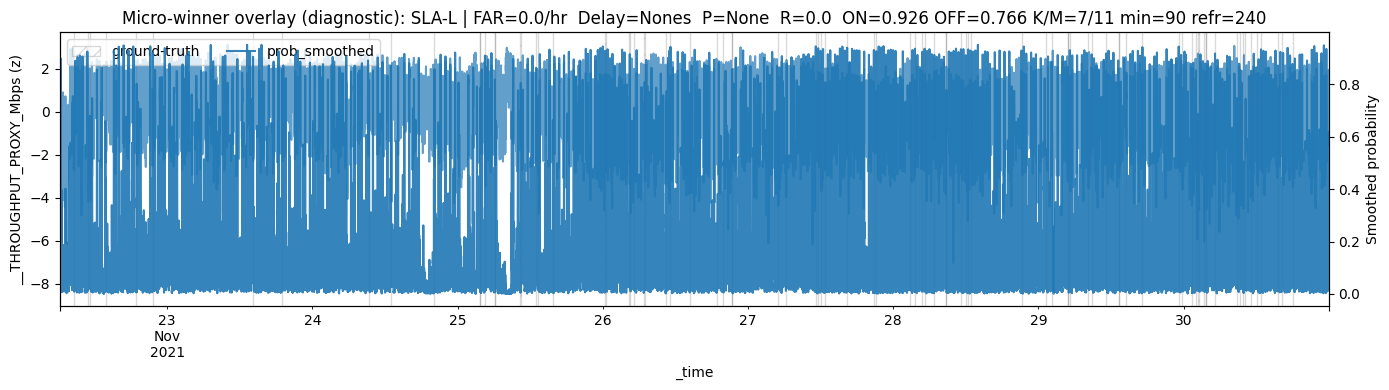

In [43]:
# 12) PICK A PRESET + OVERLAY PLOT
# -------------------------------------------------------------------------------------------------
def rank_key(d):  # FAR down, Recall up, Precision up, Delay down
    return (d["FAR/hr"], -(d["Recall"] or 0), -(d["Precision"] or 0), d["Delay_s"] if d["Delay_s"] is not None else 1e9)

winner = min([SLA_L, SLA_M, SLA_R], key=rank_key)
print("Selected micro-winner:", {k:winner[k] for k in ["Preset","FAR/hr","Delay_s","Precision","Recall","ON","OFF","K/M","Alerts"]})

# Overlay
plot_col = thr_name
proba_sm_win = winner["_proba_sm"]
stable_win   = winner["_stable"]
ev_win       = winner["_events"]
gt_win       = winner["_gt"]

fig, ax1 = plt.subplots(figsize=(14,4))
# context: throughput z-score
#s = res[plot_col].reindex(test_index)
#z = (s - s.mean())/s.std(ddof=0)
s = res[plot_col].reindex(test_index)
std = s.std(ddof=0)
z = (s - s.mean()) / (std if std > 0 else 1.0)
#
z.plot(ax=ax1, alpha=0.7, label=f"{plot_col} (z)")
ax2 = ax1.twinx()
proba_sm_win.plot(ax=ax2, alpha=0.9, label="prob_smoothed")

for s,e in ev_win:
    ax1.axvspan(s, e, alpha=0.20, color='gray', label="pred_event" if (s,e)==ev_win[0] else None)

for i,(s,e) in enumerate(gt_win):
    ax1.axvspan(s, e, alpha=0.15, hatch='//', fill=False, edgecolor='k',
                label="ground-truth" if i==0 else None)

ttl = (f'{winner["Preset"]} | FAR={winner["FAR/hr"]}/hr  Delay={winner["Delay_s"]}s  '
       f'P={winner["Precision"]}  R={winner["Recall"]}  '
       f'ON={winner["ON"]:.3f} OFF={winner["OFF"]:.3f} K/M={winner["K/M"]} '
       f'min={winner["min_dur_s"]} refr={winner["refractory_s"]}')
ax1.set_title("Micro-winner overlay (diagnostic): "+ttl)
ax1.set_ylabel(f"{plot_col} (z)"); ax2.set_ylabel("Smoothed probability")
lines, labels = [], []
for ax in [ax1, ax2]:
    L = ax.get_legend_handles_labels()
    lines.extend(L[0]); labels.extend(L[1])
if lines:
    ax1.legend(lines, labels, loc="upper left", ncol=3)
plt.tight_layout(); plt.show()





In [44]:
# 13) LOCK WINNER CONFIG + SAVE MODEL/THRESHOLDS/SCORES
# -------------------------------------------------------------------------------------------------
# Note: Prefer the adaptive lock from step 11C; else fall back to micro-winner
lock_path = os.path.join(ART_DIR, "eventization_winner.json")
if os.path.exists(lock_path):
    with open(lock_path, "r") as f:
        W = json.load(f)
    print("[Step13] Using existing lock:", W["name"])
else:
    # fallback to micro-preset 'winner' from Step 11 block
    W = {
        "name": winner["Preset"],
        "ema_span": 4,
        "on_thr": float(winner["ON"]),
        "off_thr": float(winner["OFF"]),
        "k": int(winner["K/M"].split("/")[0]),
        "m": int(winner["K/M"].split("/")[1]),
        "min_dur_s": int(winner["min_dur_s"]),
        "refractory_s": int(winner["refractory_s"]),
        "far_per_hr": float(winner["FAR/hr"]),
        "delay_s": float(winner["Delay_s"]) if winner["Delay_s"] is not None else None,
        "precision": float(winner["Precision"]) if winner["Precision"] is not None else None,
        "recall": float(winner["Recall"]) if winner["Recall"] is not None else None,
        "alerts": int(winner["Alerts"])
    }
    with open(lock_path, "w") as f:
        json.dump(W, f, indent=2)
    print("[Step13] Created lock from micro-preset:", W["name"])

# Thresholding context (validation)
thr_cfg = {
    "target_precision": float(TARGET_PRECISION),
    "tau_val": float(thr_star),
    "validation_ap": float(ap_va),
    "early_warning_min": int(EARLY_WARNING_MIN)
}
with open(os.path.join(ART_DIR, "thresholding.json"), "w") as f:
    json.dump(thr_cfg, f, indent=2)

# Save test scores — use X_test / y_test to avoid NameError
pd.DataFrame({
    "timestamp": X_test.index,
    "proba": proba_test,
    "y_true": y_test.reindex(X_test.index).values
}).to_csv(os.path.join(ART_DIR, "test_scores.csv"), index=False)

# Save model
clf.save_model(os.path.join(ART_DIR, "model_handover.json"))
print("Saved:", os.path.join(ART_DIR, "thresholding.json"))
print("Saved:", os.path.join(ART_DIR, "test_scores.csv"))
print("Saved:", os.path.join(ART_DIR, "model_handover.json"))


[Step13] Using existing lock: SLA-ADAPT-11D
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/thresholding.json
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/test_scores.csv
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/model_handover.json


In [45]:
# 14) INSPECT HANDOVER TABLE AND RULE CONTRIBUTIONS
# -------------------------------------------------------------------------------------------------
HOV_inspect = HOV.copy()
if not HOV_inspect.empty:
    HOV_inspect["rules_hit"] = (HOV_inspect[["r1_drop","r2_ping","r3_slow"]].sum(axis=1))
HOV_inspect.tail(10)


,pre,post,drop_pct,since_prev_s,recovery_s,r1_drop,r2_ping,r3_slow,anomalous,rules_hit
t,,,,,,,,,,
2021-11-30 22:05:20+00:00,220.845150,221.425733,-0.002629,410.0,0.0,0,0,0,0,0
2021-11-30 22:06:40+00:00,220.971417,221.332783,-0.001635,80.0,0.0,0,0,0,0,0
2021-11-30 22:27:30+00:00,243.274183,236.277478,0.028761,1250.0,0.0,0,0,0,0,0
2021-11-30 22:46:30+00:00,226.442333,239.621128,-0.058199,1140.0,0.0,0,0,0,0,0
2021-11-30 22:52:30+00:00,218.005292,223.210083,-0.023875,360.0,0.0,0,0,0,0,0
2021-11-30 23:10:20+00:00,223.127075,234.689611,-0.051820,1070.0,0.0,0,0,0,0,0
2021-11-30 23:14:20+00:00,232.432350,228.937222,0.015037,240.0,0.0,0,0,0,0,0
2021-11-30 23:34:30+00:00,220.738667,236.326372,-0.070616,1210.0,0.0,0,0,0,0,0
2021-11-30 23:39:40+00:00,223.659025,222.108139,0.006934,310.0,0.0,0,0,0,0,0


In [46]:
# 15) CONCLUSION SUMMARY — Beam Handover Anomalies (final export)
# ---------------------------------------------------------------
from datetime import datetime, timezone
import json, os, numpy as np, pandas as pd

# Reuse helpers from Step 11: hysteresis, n_of_m, series_to_events, prune_and_merge,
# alerts_per_hour, detection_delays_median, event_overlap_precision_recall

# Load final lock
with open(os.path.join(ART_DIR, "eventization_winner.json"), "r") as f:
    W = json.load(f)

ON, OFF = float(W["on_thr"]), float(W["off_thr"])
K, M    = int(W["k"]), int(W["m"])
MIN_DUR = int(W["min_dur_s"]); REFRACT = int(W["refractory_s"])

# Build final events on TEST
proba_sm_final = pd.Series(proba_test, index=test_index).ewm(span=W.get("ema_span",4), adjust=False).mean()
hyst = hysteresis(proba_sm_final, ON, OFF)
deb  = n_of_m((proba_sm_final >= ON).astype(int), K, M)
stable = (hyst & deb).astype(int)
pred_events = prune_and_merge(series_to_events(stable), MIN_DUR, REFRACT)

y_test_aligned = (
    pd.Series(y_test, index=getattr(y_test, 'index', test_index))
      .reindex(test_index).replace([np.inf, -np.inf], 0).fillna(0).clip(0,1).astype(int)
)
gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

TSEC = (test_index[-1] - test_index[0]).total_seconds()
far_per_hr = alerts_per_hour(pred_events, TSEC)
delay_s    = detection_delays_median(gt_events, pred_events)

def event_lead_time_median(true_events, pred_events):
    tstarts = [s for s,_ in true_events]
    pstarts = [s for s,_ in pred_events]
    if not tstarts or not pstarts: return np.nan
    leads = []
    j = 0
    for ts in tstarts:
        while j < len(pstarts) and pstarts[j] <= ts:
            j += 1
        before = pstarts[j-1] if j>0 else None
        after  = pstarts[j]   if j<len(pstarts) else None
        if before is not None: leads.append((ts - before).total_seconds())
        elif after is not None: leads.append((ts - after).total_seconds())
    return float(np.median(leads)) if leads else np.nan

lead_s     = event_lead_time_median(gt_events, pred_events)
P, R       = event_overlap_precision_recall(gt_events, pred_events, 0.10)

# Build config.json (consistent keys)
config = {
    "problem": "Beam Handover Anomalies (inferred beam_id from MODEM OUT clustering)",
    "resample": "10s",
    "beam_inference": {
        "pca_dim": int(BEAM_PCA_DIM),
        "kmeans_k": int(BEAM_K),
        "flicker_smoothing_s": 60
    },
    "handover_rules": {
        "drop_pct_thr": float(THR["drop_pct_thr"]),
        "pingpong_s":   float(THR["pingpong_s"]),
        "recovery_s_thr": float(THR["recovery_s_thr"])
    },
    "thresholding": {
        "target_precision": float(TARGET_PRECISION),
        "tau_val": float(thr_star),
        "validation_ap": float(ap_va),
        "early_warning_min": int(EARLY_WARNING_MIN)
    },
    "eventization": {
        "ema_span": int(W.get("ema_span",4)),
        "on_thr": float(ON), "off_thr": float(OFF),
        "k": int(K), "m": int(M),
        "min_dur_s": int(MIN_DUR), "refractory_s": int(REFRACT)
    },
    "metrics_test": {
        "far_per_hr": float(round(far_per_hr, 3)),
        "median_delay_s": (None if pd.isna(delay_s) else float(round(delay_s, 1))),
        "median_lead_s": (None if pd.isna(lead_s) else float(round(lead_s, 1))),
        "event_precision": (None if pd.isna(P) else float(round(P, 3))),
        "event_recall": (None if pd.isna(R) else float(round(R, 3))),
        "pred_events": int(len(pred_events)),
        "gt_events": int(len(gt_events))
    }
}

with open(os.path.join(ART_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=2)
print("Saved:", os.path.join(ART_DIR, "config.json"))

# Human-readable summary.md
summary_md = f"""
# Beam Handover Anomalies — Final Summary
**Run date (UTC):** {datetime.now(timezone.utc).isoformat(timespec='seconds')}

**Beam inference**
- MODEM *_OUT* normalized vector -> PCA({BEAM_PCA_DIM}) -> KMeans(K={BEAM_K})
- Handover = beam_id change (smoothed ≥60s)

**Anomaly rules (trained on TRAIN)**
- Post-handover throughput drop > {THR['drop_pct_thr']:.3f}
- Ping-pong within {THR['pingpong_s']:.0f}s
- Recovery time > {THR['recovery_s_thr']:.0f}s

**Model (early warning)**
- XGB on rolling throughput + beam dynamics; target=anomalous handover in {int(EARLY_WARNING_MIN)} min

**Validation**
- AP: {ap_va:.3f} | t (precision≈{TARGET_PRECISION:.2f}): {thr_star:.3f}

**Eventization preset (final)**
- EMA span: {W.get('ema_span',4)}
- ON/OFF: {ON:.3f} / {OFF:.3f}
- Debounce K/M: {K}/{M}
- Min duration / Refractory: {MIN_DUR}s / {REFRACT}s

**Test metrics (this window)**
- FAR: {far_per_hr:.3f} alerts/hour
- Median detection delay: {('NA' if pd.isna(delay_s) else f'{delay_s:.1f}')} s
- Median lead time: {('NA' if pd.isna(lead_s) else f'{lead_s:.1f}')} s
- Event Precision / Recall: {('NA' if pd.isna(P) else f'{P:.3f}')} / {('NA' if pd.isna(R) else f'{R:.3f}')}
- Pred events / GT events: {len(pred_events)} / {len(gt_events)}

**Notes**
- All thresholds learned on TRAIN only; timelines split 60/20/20.
"""
with open(os.path.join(ART_DIR, "summary.md"), "w") as f:
    f.write(summary_md.strip()+"\n")
print("Saved:", os.path.join(ART_DIR, "summary.md"))
print("\n--- HANDOVER CONCLUSION ---\n", summary_md)


Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/config.json
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_handover/summary.md

--- HANDOVER CONCLUSION ---
 
# Beam Handover Anomalies — Final Summary
**Run date (UTC):** 2025-11-19T10:53:13+00:00

**Beam inference**
- MODEM *_OUT* normalized vector -> PCA(6) -> KMeans(K=2)
- Handover = beam_id change (smoothed ≥60s)

**Anomaly rules (trained on TRAIN)**
- Post-handover throughput drop > 0.042
- Ping-pong within 300s
- Recovery time > 45s

**Model (early warning)**
- XGB on rolling throughput + beam dynamics; target=anomalous handover in 2 min

**Validation**
- AP: 0.105 | t (precision≈0.85): 0.946

**Eventization preset (final)**
- EMA span: 3
- ON/OFF: 0.926 / 0.746
- Debounce K/M: 4/7
- Min duration / Refractory: 60s / 240s

**Test metrics (this window)**
- FAR: 0.005 alerts/hour
- Median detection delay: 26405.0 s
- Median lead time: 463630.0 s
- Event Precision / Re